In [1]:
import ROOT as root
import numpy as np

np.random.seed(1234)



Welcome to JupyROOT 6.14/04


In [2]:
#
# Create data
#
# 
# mu = 1
# sigma = 0.2
# 
# data = np.random.normal(mu, sigma, 10)
# 
# print ("data = ", data)
# 
import matplotlib.pyplot as plt
# 
# fig = plt.figure(figsize = (3,3))
# plt.hist( data, bins = 50)


[0, 1, 2, 3]
data_vector_wrong_order
[[2.11280313 2.03825239 2.13752412 ... 2.14257418 2.24408162 2.39925538]
 [2.55510747 3.14026173 2.8796585  ... 3.08390621 3.0892037  3.00419331]
 [4.19905791 3.85243645 3.87018329 ... 4.12588148 4.05919405 3.21309438]
 [5.05737608 5.12412497 5.13972268 ... 4.98541489 5.17425123 5.1262775 ]]
data_vector_wrong_order_extended
[[ 5.98139944  5.79317946  4.68115651 ...  6.44936765  5.90721858
   6.51614427]
 [ 7.82890314  7.87802951  5.88875225 ...  5.94873953  8.2871106
   7.58364422]
 [ 9.58076318  8.76105997  8.28039794 ...  7.32624384  7.16751869
   8.83713724]
 [ 9.75099859  9.77466247 10.5426537  ...  7.83158819  9.06055984
  10.72059973]]
data_vector_wrong_order
[[ 2.11280313  2.03825239  2.13752412 ...  6.44936765  5.90721858
   6.51614427]
 [ 2.55510747  3.14026173  2.8796585  ...  5.94873953  8.2871106
   7.58364422]
 [ 4.19905791  3.85243645  3.87018329 ...  7.32624384  7.16751869
   8.83713724]
 [ 5.05737608  5.12412497  5.13972268 ...  7.83

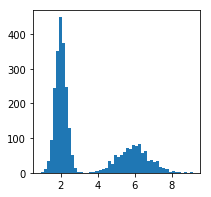

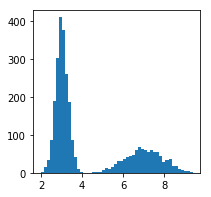

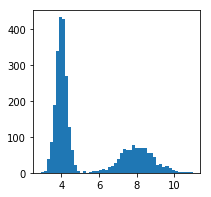

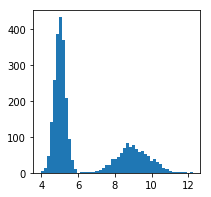

In [22]:
#
# Now create seriously more data in 2D
#

num_events = 3000

dimension_input = 4

print range(dimension_input)

mu = 2
sigma = 0.3 
data_vector_wrong_order = np.array( [ np.random.normal(mu+i, sigma, num_events*2/3)          for i in range(dimension_input)] )

data_vector_wrong_order_extended = np.array( [ np.random.normal(mu+i+4., 3*sigma, num_events/3) for i in range(dimension_input)] )

print "data_vector_wrong_order"
print data_vector_wrong_order
 
print "data_vector_wrong_order_extended"
print data_vector_wrong_order_extended

# https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.concatenate.html
data_vector_wrong_order = np.concatenate( [data_vector_wrong_order, data_vector_wrong_order_extended], axis=1)

print "data_vector_wrong_order"                                     
print data_vector_wrong_order

data_vector = np.array( [ data_vector_wrong_order[:,i] for i in range(num_events) ] )
print "data_vector"
print data_vector


for i in range(dimension_input): 
  fig = plt.figure(figsize = (3,3))  
  plt.hist( data_vector[:,i], bins = 50)




 [ 0 ][ 1 ]
 [ 0 ][ 2 ]
 [ 0 ][ 3 ]
 [ 1 ][ 2 ]
 [ 1 ][ 3 ]
 [ 2 ][ 3 ]


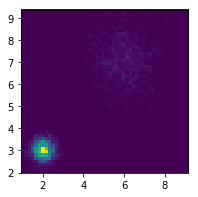

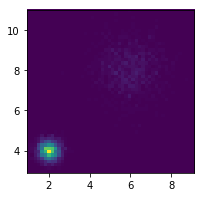

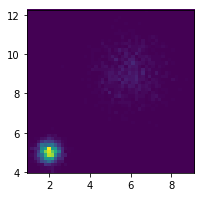

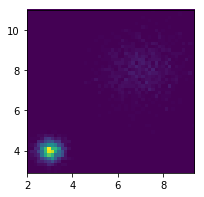

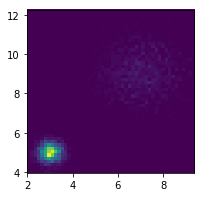

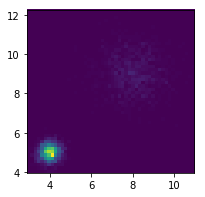

In [23]:
#
# draw 2d correlation (should be null)
#

for i in xrange(dimension_input): 
  for j in xrange(i+1, dimension_input): 
    print " [", i, "][", j, "]"
    fig = plt.figure(figsize = (3,3))  
    plt.hist2d( data_vector[:,i], data_vector[:,j], bins = 50)




In [24]:
#
#
#
# Keras model
#
#

from scipy.stats import norm

from keras import backend as K

from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential

original_dim = dimension_input
intermediate_dim = 3
latent_dim = 2
batch_size = 100
epochs = 50
epsilon_std = 1.0





In [25]:

def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """
    #
    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    #
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    #
    # See: https://keras.io/losses/
    # Cross entropy: https://en.wikipedia.org/wiki/Cross_entropy
    #


In [26]:

class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        #
        # var = variance
        #
        # print " mu = ", mu
        # print " log_var = ", log_var
        
        
        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs


In [27]:
#
# definition of the decoder
#

decoder = Sequential ([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
    ])



In [28]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

#
# h intermediate step
#
#  - mu = mean
#  - var = variance
#
# explanation see: http://louistiao.me/posts/implementing-variational-autoencoders-in-keras-beyond-the-quickstart-tutorial/
#

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

#
# from h -> 2 layers
#

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])

z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

#
# Add a new layer that takes "t" and does "exp(0.5 * t)", and apply it to "z_log_var"
# See here for more details: https://keras.io/layers/core/
#

eps = Input (tensor = K.random_normal( stddev=epsilon_std, shape=(K.shape(x)[0], latent_dim) ) )

z_eps = Multiply()([z_sigma, eps])
#
# Layer that multiplies (element-wise) a list of inputs.
# It takes as input a list of tensors, all of the same shape, and returns a single tensor (also of the same shape).
#

z = Add()([z_mu, z_eps])
#
# Layer that adds a list of inputs.
# It takes as input a list of tensors, all of the same shape, and returns a single tensor (also of the same shape).
#

x_pred = decoder(z)


In [29]:

vae = Model ( inputs=[x, eps], outputs=x_pred)
vae.compile (optimizer='rmsprop', loss=nll)


In [30]:

# train the VAE 
x_train = data_vector
x_test  = data_vector


history = vae.fit(x_train,   # source
                  x_train,   # target --> autoencoder, then the target is the same as the input
                  shuffle = True,
                  epochs = epochs,
                  batch_size = batch_size,
                  validation_data = (x_test, x_test))    # target = input also in the testing


Train on 3000 samples, validate on 3000 samples
Epoch 1/50
3000/3000 [==============================] - 0s 131us/step - loss: 29.7968 - val_loss: 21.9583
Epoch 2/50
3000/3000 [==============================] - 0s 54us/step - loss: 15.7233 - val_loss: 9.2792
Epoch 3/50
3000/3000 [==============================] - 0s 52us/step - loss: 2.6370 - val_loss: -4.6798
Epoch 4/50
3000/3000 [==============================] - 0s 58us/step - loss: -11.5461 - val_loss: -18.7354
Epoch 5/50
3000/3000 [==============================] - 0s 49us/step - loss: -23.5433 - val_loss: -30.2804
Epoch 6/50
3000/3000 [==============================] - 0s 59us/step - loss: -35.9095 - val_loss: -43.0290
Epoch 7/50
3000/3000 [==============================] - 0s 59us/step - loss: -49.3503 - val_loss: -57.7688
Epoch 8/50
3000/3000 [==============================] - 0s 49us/step - loss: -63.6939 - val_loss: -73.1068
Epoch 9/50
3000/3000 [==============================] - 0s 57us/step - loss: -80.3468 - val_loss: -89.0

In [31]:
encoder = Model(x, z_mu)



In [32]:

# display a plot of the latent space
z_test = encoder.predict(x_test, batch_size = batch_size)



In [33]:
print "z_test = ", z_test

print "x_test = ", x_test



z_test =  [[-0.98302704 -1.7029983 ]
 [-1.1544822  -1.751116  ]
 [-1.1746887  -1.6603718 ]
 ...
 [-0.9057588  -1.8564987 ]
 [-1.2587928  -1.2833155 ]
 [-1.696672   -1.3906074 ]]
x_test =  [[ 2.11280313  2.55510747  4.19905791  5.05737608]
 [ 2.03825239  3.14026173  3.85243645  5.12412497]
 [ 2.13752412  2.8796585   3.87018329  5.13972268]
 ...
 [ 6.44936765  5.94873953  7.32624384  7.83158819]
 [ 5.90721858  8.2871106   7.16751869  9.06055984]
 [ 6.51614427  7.58364422  8.83713724 10.72059973]]


latent layer


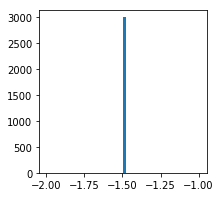

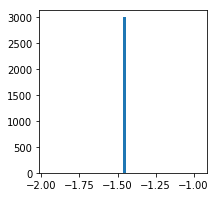

In [15]:
#plt.hist( z_test[:,0], bins = 50)
#plt.hist( x_test[:,0], bins = 50)


print "latent layer"

for inode in range(latent_dim):
  fig = plt.figure(figsize = (3,3))
  plt.hist( z_test[:,inode], bins = 50)




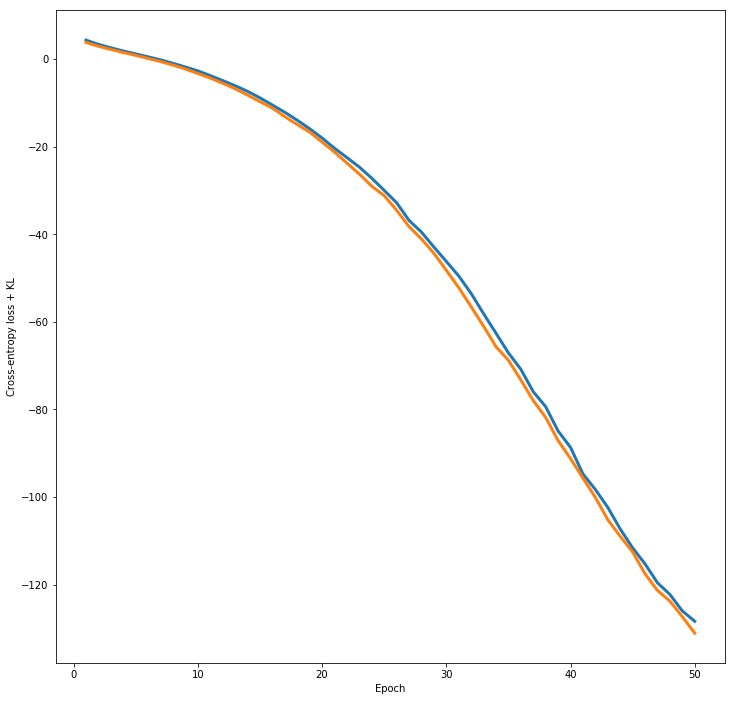

In [16]:


#########################################################
## validation plot

fig_validation = plt.figure(original_dim+latent_dim, figsize=(12,12))

epochs = range(1, len(history.history["loss"])+1)
plt.plot(epochs, history.history["loss"], lw=3, label="Training loss")
plt.plot(epochs, history.history["val_loss"], lw=3, label="Validation loss")
plt.xlabel("Epoch"), plt.ylabel("Cross-entropy loss + KL");

# print(history.history)


In [17]:

#########################################################
## plot structure of NN

from keras.utils import plot_model, print_summary
print_summary(vae)

plot_model(vae, to_file='model_plot.png', show_shapes=True, show_layer_names=True)



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 3)            15          input_1[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 2)            8           dense_3[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 2)            8           dense_3[0][0]                    
__________________________________________________________________________________________________
kl_diverge

2D: reg vs original


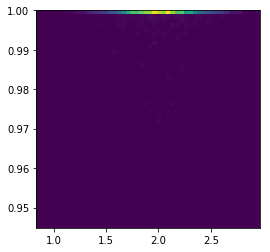

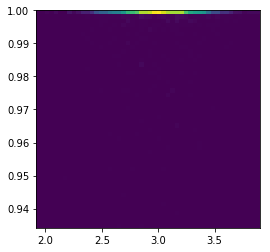

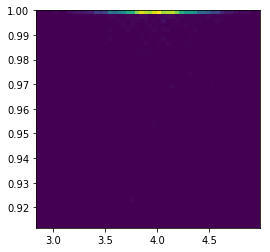

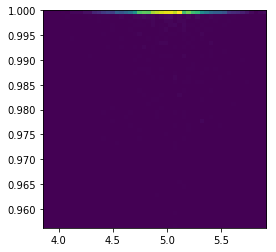

In [18]:
print "2D: reg vs original"

x_reg_test = vae.predict(x_test, batch_size = batch_size)

for inode in range(original_dim):
  fig = plt.figure(figsize = (4,4))
  plt.hist2d( x_test[:,inode], x_reg_test[:,inode], bins = 50)
    
    

input


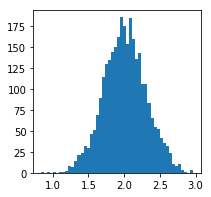

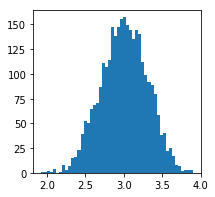

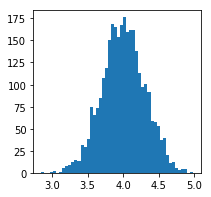

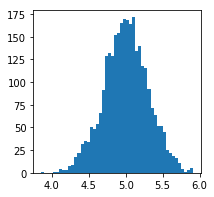

In [19]:

print "input"

for inode in range(original_dim):
  fig = plt.figure(figsize = (3,3))
  plt.hist( x_test[:,inode], bins = 50)


output


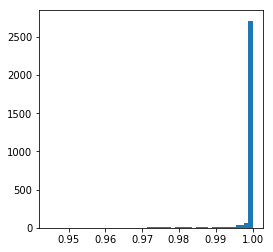

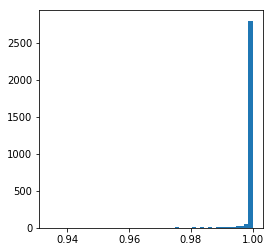

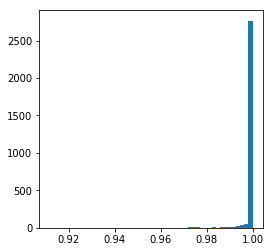

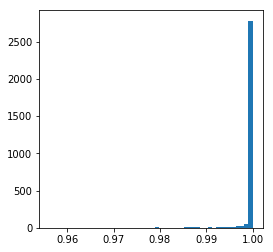

In [20]:
print "output"

for inode in range(original_dim):
   fig = plt.figure(figsize = (4,4))
   plt.hist( x_reg_test[:,inode], bins = 50)
